In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [ ]:
def clean_period(value):
    """Clean and standardize period to '20XX_s'."""
    if pd.isna(value):
        return None
    value = str(value).lower().strip()
    match = re.search(r"(\d{4})\D*s?(\d)", value)
    if match:
        year, semester = match.groups()
        if semester in ['1', '2']:  # Only allow s1 or s2
            return f"{year}_s{int(semester)}"
    return None

def convert_period_to_date(period):
    """Convert 'YYYY_s1' or 'YYYY_s2' to datetime ('YYYY_06' or 'YYYY_12')."""
    if pd.isna(period):
        return None
    period = period.lower().strip().replace("s1", "06").replace("s2", "12")
    try:
        return pd.to_datetime(period, format="%Y_%m")
    except:
        return None


def prepare_data_for_prophet(df, airport_name):
    """Prepare data for Prophet with 'ds' and 'y' columns."""
    airport_data = df[df['airport'] == airport_name].copy()
    airport_data['period'] = airport_data['period'].apply(clean_period)
    airport_data['date'] = airport_data['period'].apply(convert_period_to_date)
    airport_data = airport_data.dropna(subset=['period', 'date', 'traffic'])
    airport_data = airport_data.sort_values('date')
    prophet_df = pd.DataFrame({'ds': airport_data['date'], 'y': airport_data['traffic']})
    return prophet_df

def add_custom_seasonalities_and_events(model):
    """Add custom seasonalities and holidays."""
    ramadan_dates = pd.DataFrame([
        {'holiday': 'ramadan_impact', 'ds': date, 'lower_window': -15, 'upper_window': 15}
        for date in ['2014-06-28','2015-06-17','2016-06-06','2017-05-26','2018-05-15', '2019-05-06', '2020-04-24', '2021-04-13',
                     '2022-04-02', '2023-03-22', '2024-03-11', '2025-02-28', '2026-02-18']
    ])
    hajj_dates = pd.DataFrame([
        {'holiday': 'hajj_impact', 'ds': date, 'lower_window': -5, 'upper_window': 5}
        for date in ['2014-10-02','2015-09-21','2016-09-10','2017-08-30','2018-08-19', '2019-08-09', '2020-07-28', '2021-07-17',
                     '2022-07-07', '2023-06-26', '2024-06-14', '2025-06-04', '2026-05-29']
    ])
    covid_dates = pd.DataFrame([
        {'holiday': 'covid_lockdown', 'ds': '2020-03-20', 'lower_window': -10, 'upper_window': 180},
        {'holiday': 'covid_recovery', 'ds': '2021-06-01', 'lower_window': -30, 'upper_window': 365},
    ])
    summer_dates = pd.DataFrame([
        {'holiday': 'summer_peak', 'ds': f'{year}-07-15', 'lower_window': -30, 'upper_window': 30}
        for year in range(2014, 2027)
    ])
    
    holidays = pd.concat([ramadan_dates, hajj_dates, covid_dates, summer_dates])
    holidays['ds'] = pd.to_datetime(holidays['ds'])
    return holidays

def create_prophet_model(df_prophet, airport_name):
    """Initialize, configure and fit Prophet model."""
    model = Prophet(
        growth='linear',
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=2,
        n_changepoints=30,
        interval_width=0.95
    )
    holidays = add_custom_seasonalities_and_events(model)
    model.holidays = holidays
    print(f"Training Prophet model for {airport_name}...")
    model.fit(df_prophet)
    return model

def make_forecast(model, periods=4):
    """Forecast next N semesters (periods=4 => 2 years)."""
    future = model.make_future_dataframe(periods=periods, freq='6MS')
    forecast = model.predict(future)
    forecast['ds'] = pd.to_datetime(forecast['ds'])
    return forecast, future

def evaluate_model(df_prophet, forecast, train_size=0.8):
    """Evaluate forecast using train/test split."""
    split_idx = int(len(df_prophet) * train_size)
    train_data = df_prophet.iloc[:split_idx]
    test_data = df_prophet.iloc[split_idx:]

    if len(test_data) == 0:
        print("Not enough data for evaluation")
        return None

    model_eval = Prophet(
        growth='linear',
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10
    )
    model_eval.fit(train_data)
    future_eval = model_eval.make_future_dataframe(periods=len(test_data), freq='6MS')
    forecast_eval = model_eval.predict(future_eval)

    test_predictions = forecast_eval.iloc[-len(test_data):]['yhat'].values
    test_actual = test_data['y'].values

    mae = mean_absolute_error(test_actual, test_predictions)
    mse = mean_squared_error(test_actual, test_predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_actual - test_predictions) / test_actual)) * 100

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'test_actual': test_actual,
        'test_predictions': test_predictions
    }

def plot_forecast(model, forecast, df_prophet, airport_name):
    """Plot forecast, trend, seasonality, and residuals."""
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f'{airport_name} - Prophet Forecast Analysis', fontsize=16, fontweight='bold')

    ax1 = axes[0, 0]
    model.plot(forecast, ax=ax1)
    ax1.set_title('Traffic Forecast with Confidence Intervals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Traffic (Passengers)')
    ax1.grid(True, alpha=0.3)

    ax2 = axes[0, 1]
    trend = forecast[['ds', 'trend']].set_index('ds')
    trend.plot(ax=ax2, color='red', linewidth=2)
    ax2.set_title('Trend Component')
    ax2.set_ylabel('Trend')
    ax2.grid(True, alpha=0.3)

    ax3 = axes[1, 0]
    if 'yearly' in forecast.columns:
        yearly = forecast[['ds', 'yearly']].set_index('ds')
        yearly.plot(ax=ax3, color='green', linewidth=2)
    ax3.set_title('Yearly Seasonality')
    ax3.set_ylabel('Seasonal Effect')
    ax3.grid(True, alpha=0.3)

    ax4 = axes[1, 1]
    historical_forecast = forecast[forecast['ds'] <= df_prophet['ds'].max()]
    residuals = df_prophet.set_index('ds')['y'] - historical_forecast.set_index('ds')['yhat']
    residuals.plot(ax=ax4, color='purple', marker='o')
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax4.set_title('Residuals (Actual - Predicted)')
    ax4.set_ylabel('Residuals')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_components(model, forecast):
    """Plot Prophet internal seasonalities."""
    fig = model.plot_components(forecast, figsize=(12, 8))
    plt.tight_layout()
    plt.show()

def forecast_summary(forecast, airport_name, last_train_date):
    print(f"\n{'='*50}")
    print(f"FORECAST SUMMARY FOR {airport_name}")
    print(f"{'='*50}")

    future_forecast = forecast[forecast['ds'] > last_train_date].copy()
    future_forecast['ds'] = pd.to_datetime(future_forecast['ds'])  # Ensure datetime

    if len(future_forecast) > 0:
        print(f"\nForecast Period: {future_forecast['ds'].min().strftime('%Y-%m')} to {future_forecast['ds'].max().strftime('%Y-%m')}")
        print("\nDetailed Forecasts:")
        print("-" * 70)

        for _, row in future_forecast.iterrows():
            ds = pd.to_datetime(row['ds'])
            period = "S1" if ds.month == 6 else "S2"
            print(f"{ds.year} {period}: {row['yhat']:,.0f} passengers [{row['yhat_lower']:,.0f} - {row['yhat_upper']:,.0f}]")

        first_forecast = future_forecast.iloc[0]['yhat']
        last_forecast = future_forecast.iloc[-1]['yhat']
        total_growth = ((last_forecast - first_forecast) / first_forecast) * 100

        # Ensure min/max are datetime before subtraction
        min_ds = pd.to_datetime(future_forecast['ds'].min())
        max_ds = pd.to_datetime(future_forecast['ds'].max())
        years = (max_ds - min_ds).days / 365.25
        if years > 0:
            annual_growth = (((last_forecast / first_forecast) ** (1/years)) - 1) * 100
            print(f"Average Annual Growth Rate: {annual_growth:.1f}%")

# ----------------------------
# Main pipeline
# ----------------------------

def main():
    print("Loading data...")
    df = pd.read_csv("trafic_ma_long_clean_new.csv")

    airports = ['agadir', 'casablanca', 'fes_saiss', 'marrakech', 'rabat_sale']
    all_forecasts = {}
    all_evaluations = {}

    print(df.columns)
    print(df.head())

    for airport in airports:
        print(f"\n{'='*60}")
        print(f"PROCESSING {airport}")
        print(f"{'='*60}")
        try:
            df_prophet = prepare_data_for_prophet(df, airport)
            if len(df_prophet) < 4:
                print(f"Not enough data for {airport}. Skipping...")
                continue

            model = create_prophet_model(df_prophet, airport)
            forecast, _ = make_forecast(model, periods=4)

            all_forecasts[airport] = {
                'model': model,
                'forecast': forecast,
                'data': df_prophet
            }

            if len(df_prophet) >= 6:
                evaluation = evaluate_model(df_prophet, forecast)
                if evaluation:
                    all_evaluations[airport] = evaluation
                    print("\nModel Performance Metrics:")
                    print(f"MAE: {evaluation['MAE']:,.0f}")
                    print(f"RMSE: {evaluation['RMSE']:,.0f}")
                    print(f"MAPE: {evaluation['MAPE']:.2f}%")

            plot_forecast(model, forecast, df_prophet, airport)
            plot_components(model, forecast)

            forecast_summary(forecast, airport, df_prophet['ds'].max())

        except Exception as e:
            print(f"Error processing {airport}: {str(e)}")
            continue

    if len(all_forecasts) > 1:
        plt.figure(figsize=(15, 10))
        colors = plt.cm.Set3(np.linspace(0, 1, len(all_forecasts)))
        for i, (airport, data) in enumerate(all_forecasts.items()):
            forecast = data['forecast']
            df_prophet = data['data']
            plt.plot(df_prophet['ds'], df_prophet['y'], 'o-', color=colors[i], label=f'{airport} (Historical)', alpha=0.7)
            future_data = forecast[forecast['ds'] > df_prophet['ds'].max()]
            plt.plot(future_data['ds'], future_data['yhat'], '--', color=colors[i], label=f'{airport} (Forecast)', linewidth=2)
            plt.fill_between(future_data['ds'], future_data['yhat_lower'], future_data['yhat_upper'], alpha=0.2, color=colors[i])
        plt.title('All Airports - Traffic Forecast Comparison', fontsize=16, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Traffic (Passengers)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    if all_evaluations:
        print(f"\n{'='*60}")
        print("MODEL PERFORMANCE COMPARISON")
        print(f"{'='*60}")
        eval_df = pd.DataFrame(all_evaluations).T
        print(eval_df.round(2))
        best_model = eval_df['MAPE'].idxmin()
        print(f"\nBest performing model (lowest MAPE): {best_model}")

    print(f"\n{'='*60}")
    print("FORECASTING COMPLETE")
    print(f"{'='*60}")

Loading data...
Index(['Unnamed: 0', 'airport', 'year', 'semester', 'traffic', 'period'], dtype='object')
   Unnamed: 0 airport  year semester   traffic   period
0           0  agadir  2009       s1       NaN  2009_s1
1           1  agadir  2009       s2       NaN  2009_s2
2           2  agadir  2010       s1  762741.0  2010_s1
3           3  agadir  2010       s2  864744.0  2010_s2
4           4  agadir  2011       s1  771894.0  2011_s1

PROCESSING agadir
Training Prophet model for agadir...


14:14:58 - cmdstanpy - INFO - Chain [1] start processing
14:15:25 - cmdstanpy - INFO - Chain [1] done processing
14:15:25 - cmdstanpy - INFO - Chain [1] start processing
14:15:25 - cmdstanpy - INFO - Chain [1] done processing



Model Performance Metrics:
MAE: 423,905
RMSE: 526,324
MAPE: 43.50%


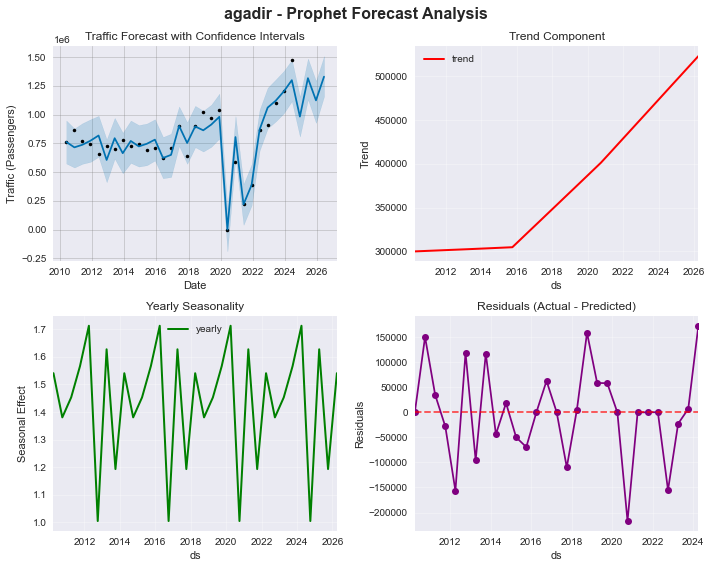

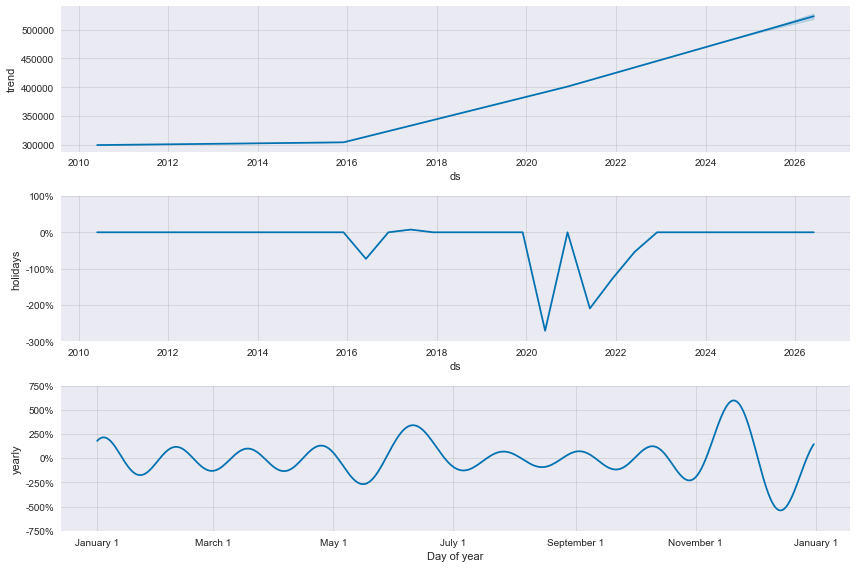

14:15:27 - cmdstanpy - INFO - Chain [1] start processing



FORECAST SUMMARY FOR agadir

Forecast Period: 2024-12 to 2026-06

Detailed Forecasts:
----------------------------------------------------------------------
2024 S2: 982,344 passengers [808,984 - 1,152,771]
2025 S1: 1,316,203 passengers [1,131,667 - 1,486,091]
2025 S2: 1,123,212 passengers [927,611 - 1,291,447]
2026 S1: 1,329,144 passengers [1,158,102 - 1,507,866]
Average Annual Growth Rate: 22.4%

PROCESSING casablanca
Training Prophet model for casablanca...


14:15:49 - cmdstanpy - INFO - Chain [1] done processing
14:15:49 - cmdstanpy - INFO - Chain [1] start processing
14:15:49 - cmdstanpy - INFO - Chain [1] done processing



Model Performance Metrics:
MAE: 942,146
RMSE: 1,252,412
MAPE: 22.40%


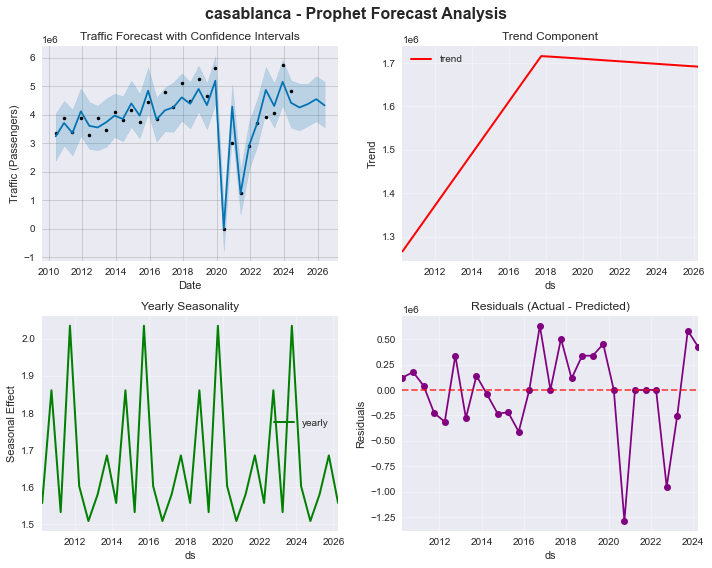

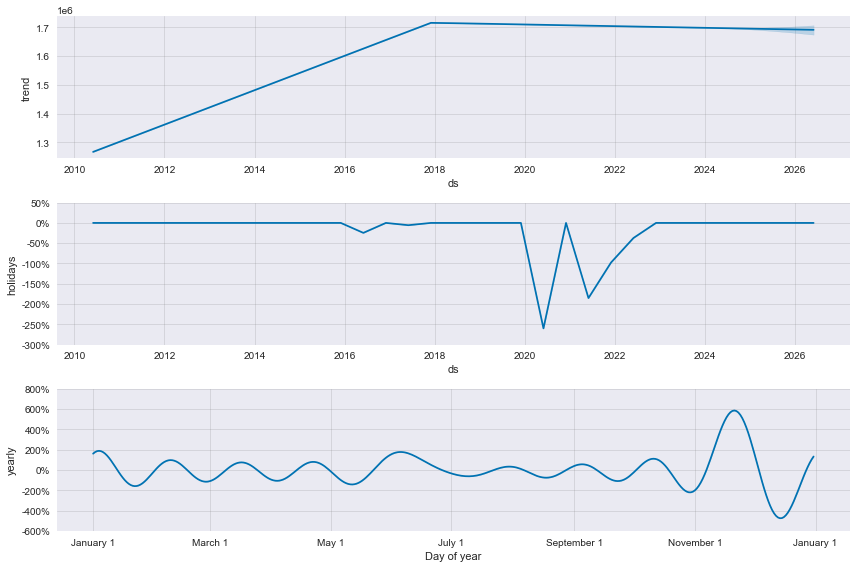

14:15:50 - cmdstanpy - INFO - Chain [1] start processing



FORECAST SUMMARY FOR casablanca

Forecast Period: 2024-12 to 2026-06

Detailed Forecasts:
----------------------------------------------------------------------
2024 S2: 4,252,936 passengers [3,449,933 - 5,088,083]
2025 S1: 4,371,710 passengers [3,604,974 - 5,087,441]
2025 S2: 4,545,665 passengers [3,768,760 - 5,357,453]
2026 S1: 4,324,661 passengers [3,551,549 - 5,153,486]
Average Annual Growth Rate: 1.1%

PROCESSING fes_saiss
Training Prophet model for fes_saiss...


14:16:14 - cmdstanpy - INFO - Chain [1] done processing
14:16:14 - cmdstanpy - INFO - Chain [1] start processing
14:16:14 - cmdstanpy - INFO - Chain [1] done processing



Model Performance Metrics:
MAE: 206,008
RMSE: 262,786
MAPE: 25.56%


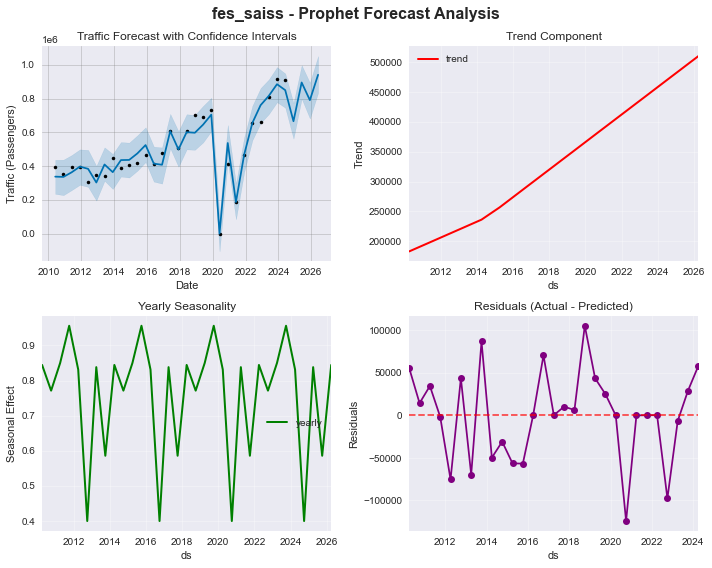

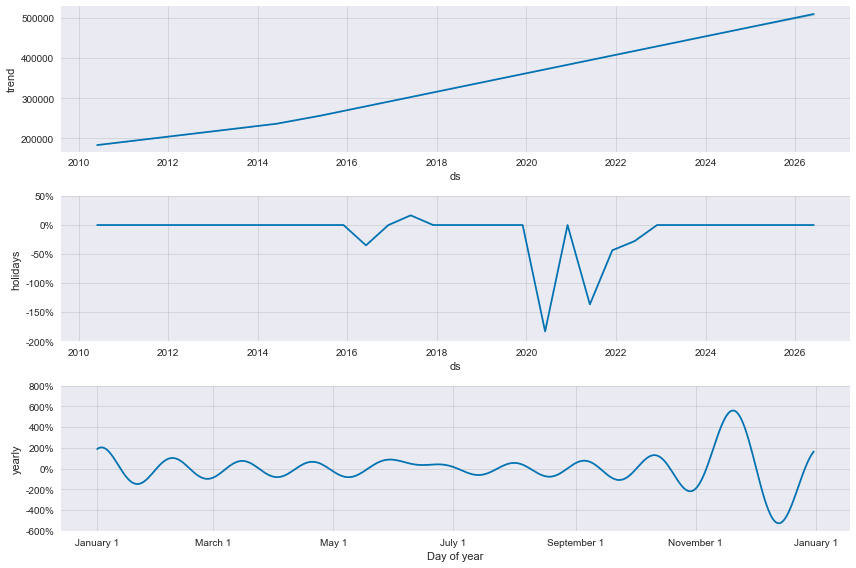


FORECAST SUMMARY FOR fes_saiss

Forecast Period: 2024-12 to 2026-06

Detailed Forecasts:
----------------------------------------------------------------------
2024 S2: 665,930 passengers [562,443 - 773,008]
2025 S1: 895,601 passengers [799,520 - 997,758]
2025 S2: 790,947 passengers [681,869 - 893,967]
2026 S1: 941,152 passengers [834,635 - 1,051,859]
Average Annual Growth Rate: 26.0%

PROCESSING marrakech
Training Prophet model for marrakech...


14:16:15 - cmdstanpy - INFO - Chain [1] start processing
14:16:47 - cmdstanpy - INFO - Chain [1] done processing
14:16:47 - cmdstanpy - INFO - Chain [1] start processing
14:16:47 - cmdstanpy - INFO - Chain [1] done processing



Model Performance Metrics:
MAE: 1,058,097
RMSE: 1,425,520
MAPE: 45.78%


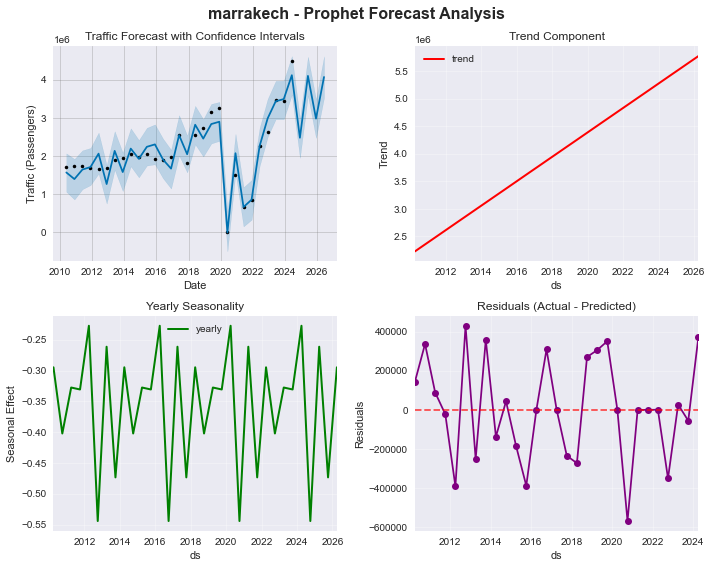

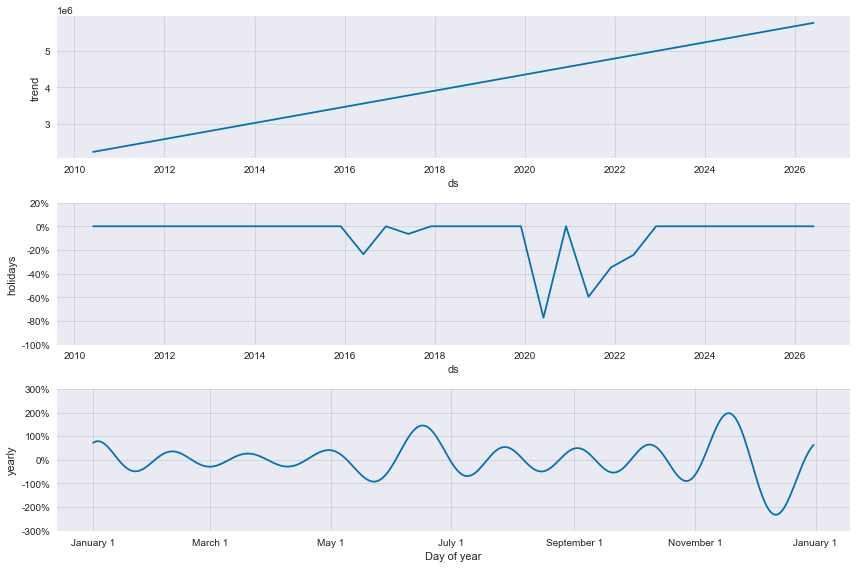

14:16:48 - cmdstanpy - INFO - Chain [1] start processing



FORECAST SUMMARY FOR marrakech

Forecast Period: 2024-12 to 2026-06

Detailed Forecasts:
----------------------------------------------------------------------
2024 S2: 2,481,049 passengers [1,955,079 - 2,982,361]
2025 S1: 4,102,869 passengers [3,589,742 - 4,602,819]
2025 S2: 2,983,440 passengers [2,476,850 - 3,481,833]
2026 S1: 4,073,412 passengers [3,533,716 - 4,614,321]
Average Annual Growth Rate: 39.2%

PROCESSING rabat_sale
Training Prophet model for rabat_sale...


14:17:04 - cmdstanpy - INFO - Chain [1] done processing
14:17:05 - cmdstanpy - INFO - Chain [1] start processing
14:17:05 - cmdstanpy - INFO - Chain [1] done processing



Model Performance Metrics:
MAE: 126,787
RMSE: 184,460
MAPE: 23.15%


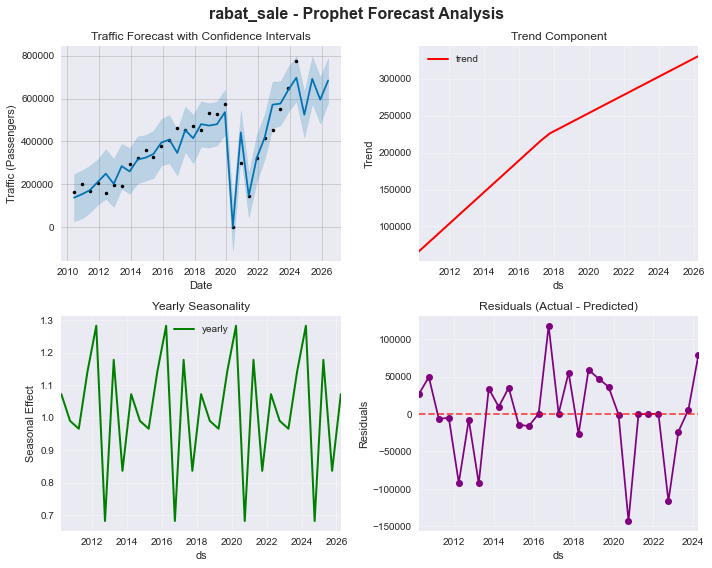

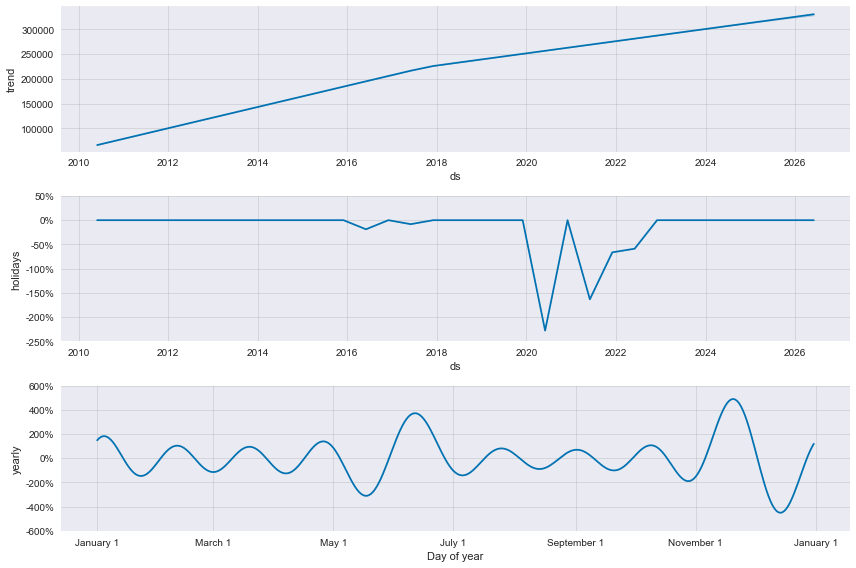


FORECAST SUMMARY FOR rabat_sale

Forecast Period: 2024-12 to 2026-06

Detailed Forecasts:
----------------------------------------------------------------------
2024 S2: 524,905 passengers [418,247 - 632,651]
2025 S1: 692,979 passengers [577,647 - 797,430]
2025 S2: 595,632 passengers [483,458 - 701,688]
2026 S1: 684,823 passengers [579,274 - 789,195]
Average Annual Growth Rate: 19.4%


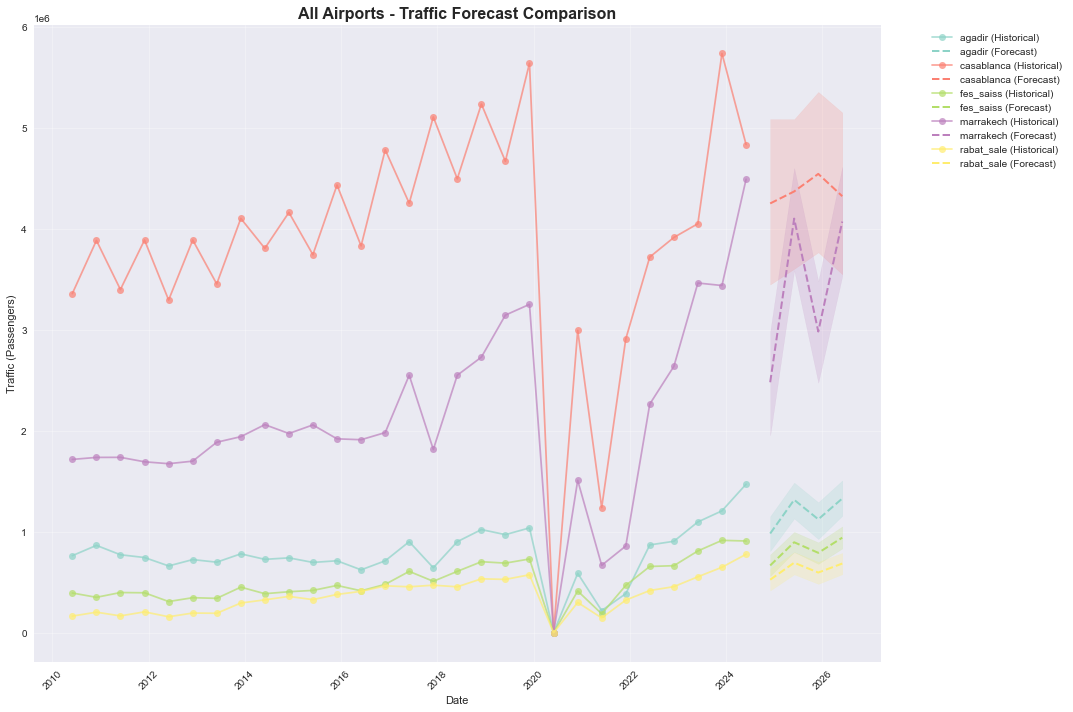


MODEL PERFORMANCE COMPARISON
                       MAE                   MSE            RMSE       MAPE  \
agadir       423904.874803   277017119138.469849   526324.157852  43.503767   
casablanca    942146.09259  1568535737287.456299  1252411.967879  22.403587   
fes_saiss    206007.628661    69056433839.140182   262785.908753  25.558669   
marrakech   1058097.278171  2032108230978.617188  1425520.336922  45.782295   
rabat_sale   126787.096315    34025623040.557541   184460.356284  23.150007   

                                                  test_actual  \
agadir      [386530.0, 869271.0, 905334.0, 1096971.0, 1207...   
casablanca  [2911103.0, 3721753.0, 3915890.0, 4052030.0, 5...   
fes_saiss   [468221.0, 655868.0, 663324.0, 809514.0, 91455...   
marrakech   [858489.0, 2264759.0, 2638922.0, 3464327.0, 34...   
rabat_sale  [322682.0, 417507.0, 455798.0, 553697.0, 64797...   

                                             test_predictions  
agadir      [683137.9255448638, 655566.4

In [89]:
if __name__ == "__main__":
    main()